In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [45]:
%%R
physeq = import_biom("../../SeqData/Funguilds/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [47]:
%%R

#physeq = subset_samples(physeq, Sample!=)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

#ps.merged = subset_samples(ps.merged,row.names(sample_data(ps.merged))!="S_2.5_14")
# Removing soil sample with large Onygenales taxon (Emmonsia) - soil saprotroph, but huge

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

In [84]:
%%R
Funguilds = read.csv("../../SeqData/Funguilds/Funguild.guilds.txt",sep="\t")
# Import funguilds file
tt = data.frame(tax_table(physeq))
tt$OTU_ID = rownames(tt)
# Get taxonomy from phyloseq object and include its rownames
combined = join(tt,Funguilds,type="left",by="OTU_ID")
# Combine the Funguilds and taxonomy tables
rownames(combined) = combined$OTU_ID
# Make sure it'll look like the taxonomy table
tax_table(physeq)=as.matrix(combined)
# Convert the combined table to a matrix and assign it as the new taxonomy table
head(tax_table(physeq))
# Ok, now our tax table has the funguilds assignments

        Kingdom        Phylum           Class           Order            Family
OTU_4     Fungi    Ascomycota  Eurotiomycetes      Eurotiales    Trichocomaceae
OTU_568   Fungi    Ascomycota  Eurotiomycetes Chaetothyriales      unidentified
OTU_5     Fungi    Ascomycota Sordariomycetes     Sordariales Lasiosphaeriaceae
OTU_9     Fungi Basidiomycota  Agaricomycetes     Sebacinales      unidentified
OTU_3     Fungi    Ascomycota  Eurotiomycetes      Onygenales  Ajellomycetaceae
OTU_64     <NA>          <NA>            <NA>            <NA>              <NA>
               Genus            Species      Rank1  OTU_ID       Taxon
OTU_4    Penicillium               <NA>       <NA>   OTU_4 Penicillium
OTU_568 unidentified Chaetothyriales sp       <NA> OTU_568           -
OTU_5           <NA>               <NA>       <NA>   OTU_5           -
OTU_9   unidentified     Sebacinales sp       <NA>   OTU_9           -
OTU_3       Emmonsia               <NA>       <NA>   OTU_3    Emmonsia
OTU_64        

In [91]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [6 x 2]

           Trtmt total
1          Blank     1
2   Ferrihydrite    18
3 Heavy Fraction     3
4      Kaolinite    17
5         Quartz    18
6           Soil    16


In [92]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Ferrihydrite","Quartz","Kaolinite"))
#<-variables[c(1,2,4,5,6,7,8),]
variables

         Trtmt
1 Ferrihydrite
2       Quartz
3    Kaolinite


In [110]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == c(2.5,3.0)) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == c(2.5,3.0)) & (sample_data(physeq)$Trtmt == "Soil")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>1500, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Soil")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq, cooksCutoff=TRUE)
# Change CooksCutoff to stop outliers (FALSE leaves them in)
    results$Trtmt = Trtmt
    results = data.frame(results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:14])
    colnames(results) = c("Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species","Other","OTU_ID","taxon","taxon.level","trophic.mode","guild","confidence")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [111]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [112]:
%%R
FDR = 0.10

threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=FDR, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

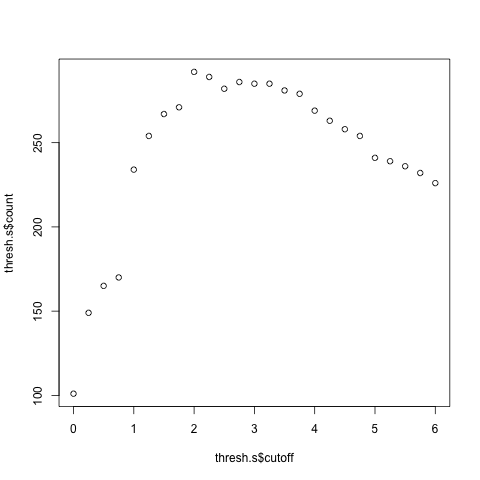

In [113]:
%%R
range = seq(0,6,0.25)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [114]:
%%R
group_by(DA, Trtmt) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=2) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fcCombMonths.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [115]:
%%R
l2fc<-read.csv("../../SeqData/l2fcCombMonths.csv")

In [116]:
%%R
dim(l2fc[is.na(l2fc$padj)==TRUE,])/(dim(l2fc[is.na(l2fc$padj)==FALSE,])+dim(l2fc[is.na(l2fc$padj)==TRUE,]))
# Fraction of OTUs that were designated as "outliers" - way more in the fungi

[1] 0.4410977 0.5000000


In [117]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(Trtmt)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(Trtmt)%>%
    count(Trtmt,Sig)%>%
    group_by(Trtmt)%>%
    mutate(Fraction=n/sum(n))
mean(d$Fraction[d$Sig==1])

[1] 0.05427507


In [118]:
%%R
head(l2fc)

         Trtmt    OTU   baseMean      l2FC       SE     pvalue Kingdom
1 Ferrihydrite  OTU_4  952.45880 -2.501766 1.014986 0.01370791   Fungi
2 Ferrihydrite  OTU_5 1067.27885 -1.254673 1.488857 0.39939137   Fungi
3 Ferrihydrite  OTU_9 2168.94063  3.507323 1.487046 0.01834476   Fungi
4 Ferrihydrite OTU_64   69.74798 -1.515017 1.858084 0.41486331    <NA>
5 Ferrihydrite  OTU_8    8.12393  4.215796 2.352903         NA   Fungi
6 Ferrihydrite OTU_23  283.11971 -1.856509 1.139189 0.10316998   Fungi
         Phylum           Class        Order            Family        Genus
1    Ascomycota  Eurotiomycetes   Eurotiales    Trichocomaceae  Penicillium
2    Ascomycota Sordariomycetes  Sordariales Lasiosphaeriaceae         <NA>
3 Basidiomycota  Agaricomycetes  Sebacinales      unidentified unidentified
4          <NA>            <NA>         <NA>              <NA>         <NA>
5    Ascomycota   Leotiomycetes   Helotiales   Rutstroemiaceae         <NA>
6 Rozellomycota    unidentified unidentified   

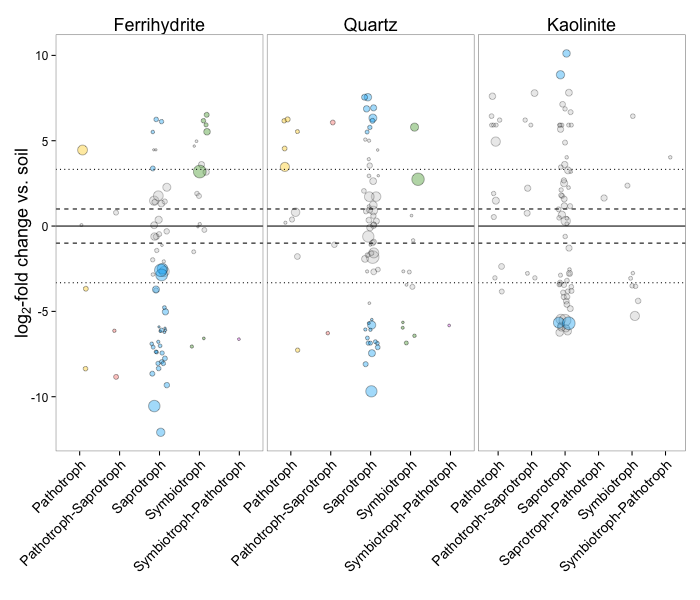

In [148]:
%%R -w 700 -h 600
# setting the image sizes, then making the figure...

d = l2fc %>%
    mutate(sig = ifelse(padj<0.1,1,0))%>%
    filter(pvalue != 'NA')%>%
    filter(taxon != "-")%>%
    group_by(Trtmt) %>%
    mutate(relabund=baseMean/Total)

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz","Kaolinite"))

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = ggplot()
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.
    
p = p + geom_point(data=d.no, aes(x = trophic.mode, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.yes, aes(x = trophic.mode, y = l2FC, fill = trophic.mode, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
    
p = p + facet_grid(~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns
    
p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 18),
              #strip.text.y = element_text(size = 18),
              strip.text.y = element_blank(),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.title.x = element_text(size = 18),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 18),
              legend.title = element_text(size=18),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

#ylabel = expression(paste("", log[2],"-fold change",sep=""))
#ylabel =  str(c(ylabel,"\n vs. soil"))
#p = p + labs(y = ylabel)
p = p + labs(y = expression(paste(log[2],"-fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + theme(axis.title.y = element_text(vjust=0))
    
p = p + scale_fill_manual(values = c("grey","#FDD017","#F8766D","#00B0F6","#4AA02C","#E76BF3","pink"), guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p

In [40]:
%%R
ggsave(filename="DiffAbundITSFunguildsCombMonths.jpg", plot=p ,width=6, height=6)

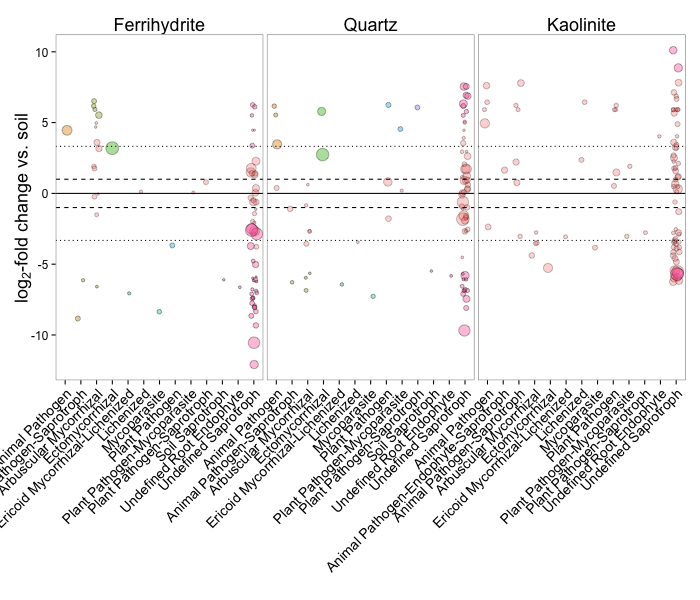

In [151]:
%%R -w 700 -h 600
# setting the image sizes, then making the figure...

d = l2fc %>%
    mutate(sig = ifelse(padj<0.1,1,0))%>%
    filter(pvalue != 'NA')%>%
    filter(taxon != "-")%>%
    group_by(Trtmt) %>%
    mutate(relabund=baseMean/Total)

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz","Kaolinite"))

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = ggplot()
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.
    
p = p + geom_point(data=d.no, aes(x = guild, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.yes, aes(x = guild, y = l2FC, fill = guild, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
    
p = p + facet_grid(~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns
    
p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 18),
              #strip.text.y = element_text(size = 18),
              strip.text.y = element_blank(),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.title.x = element_text(size = 18),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 18),
              legend.title = element_text(size=18),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

#ylabel = expression(paste("", log[2],"-fold change",sep=""))
#ylabel =  str(c(ylabel,"\n vs. soil"))
#p = p + labs(y = ylabel)
p = p + labs(y = expression(paste(log[2],"-fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + theme(axis.title.y = element_text(vjust=0))
    
#p = p + scale_fill_manual(values = c("grey","#FDD017","#F8766D","#00B0F6","#4AA02C","#E76BF3","pink"), guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p

## Of enriched taxa, breakdown?

In [141]:
%%R

cutoff=2
abund=0.0005

d.high = l2fc %>%
    dplyr::filter(l2FC>cutoff, padj<=0.1)%>%
    dplyr::group_by(Trtmt) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::mutate(name=ifelse(is.na(Genus),paste("unidentified"),ifelse(is.na(Species),paste(Genus,"sp."),paste(Species))))%>%
    dplyr::mutate(Tax=trophic.mode)%>%
    dplyr::filter(Tax!="-")%>%
    dplyr::filter(confidence==c("Highly Probable","Probable"))%>%
    dplyr::group_by(Trtmt,Tax)%>%
    dplyr::summarise(totabund=sum(relabund))%>%
    dplyr::mutate(Tax=ifelse(is.na(Tax), "unidentified", paste(Tax)))%>%
    dplyr::group_by(Trtmt,Tax)%>%
    dplyr::summarise(totabund=sum(totabund))

colnames(d.high) <- c("Trtmt","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
len = length(mean.Abund[order(-mean.Abund$M),]$Tax)
levs = c(mean.Abund[order(-mean.Abund$M),]$Tax[1],mean.Abund[order(-mean.Abund$M),]$Tax[3:len],mean.Abund[order(-mean.Abund$M),]$Tax[2])
d.high$Tax = factor(d.high$Tax, levels=levs)
#d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

d.plot = d.high

head(d.plot)

Source: local data frame [6 x 3]
Groups: Trtmt

         Trtmt         Tax     relabund
1 Ferrihydrite  Pathotroph 0.0502927169
2       Quartz  Pathotroph 0.0520328009
3 Ferrihydrite Symbiotroph 0.0015504336
4 Ferrihydrite  Saprotroph 0.0005498345
5    Kaolinite  Saprotroph 0.0347627935
6       Quartz  Saprotroph 0.0074767305


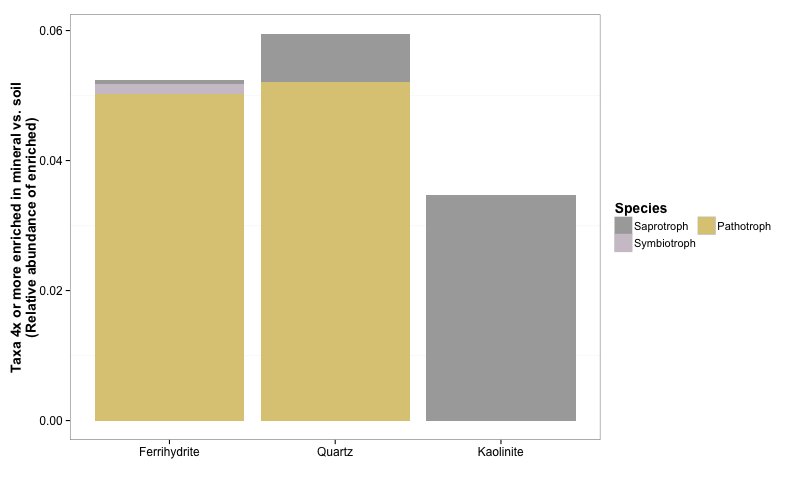

In [142]:
%%R -w 800

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
len = length(colors)
colors[len] = 'darkgrey'

p = ggplot(d.plot, aes(x=Trtmt, y=relabund, fill = Tax))

N=45
Breaks=factor(d.plot$Tax, d.plot[order(-d.plot$relabund),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks=Breaks)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Species", ncol = 2, reverse=TRUE))

p = p + xlab("") + ylab("Taxa 4x or more enriched in mineral vs. soil\n(Relative abundance of enriched)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="right")
p = p + theme(strip.background = element_blank(),strip.text = element_text(size=14), panel.grid.major= element_blank())

p

In [129]:
%%R
ggsave(filename="DAITSSpeciesCutoff2FunGuildsCombMonths.jpg", p, width=8, height=5)

###Making pos/neg figure

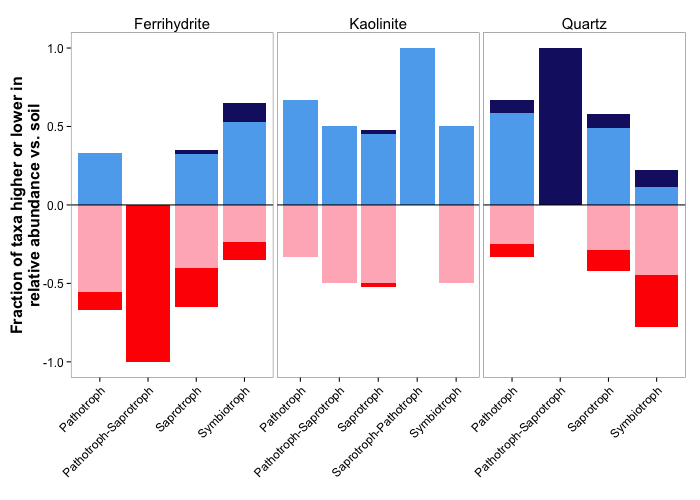

In [145]:
%%R -h 500 -w 700

FDR = 0.1

d = l2fc

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))

d = l2fc %>%
    filter(confidence==c("Highly Probable","Probable"))%>%
    group_by(trophic.mode,Trtmt)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,ifelse((padj >= FDR),0,1)))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(trophic.mode,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(trophic.mode,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(trophic.mode,Trtmt)%>%
    mutate(Sum = sum(n))%>%
    mutate(Shade = log(Sum))%>%
    arrange(trophic.mode)

d.pos = subset(d,Resp>0)
d.neg = subset(d,Resp<0)
d.pos$trophic.mode <- factor(d.pos$trophic.mode)
d.neg$trophic.mode <- factor(d.neg$trophic.mode)

p = ggplot()
#p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack") 
#p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack")
p = p + geom_bar(data=d.pos, aes(x=trophic.mode,y=Fract,fill=RespSignif),stat="identity", position="stack") 
p = p + geom_bar(data=d.neg, aes(x=trophic.mode,y=Fract,fill=RespSignif),stat="identity", position="stack")
#p = p + scale_x_discrete(limits=PhylumOrder)
p = p + facet_grid(~Trtmt,scales="free_x")
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(size = 12, angle=45, hjust=1))
p = p + theme(axis.text.y = element_text(size = 12))
p = p + scale_fill_manual(values=c("lightpink","red","steelblue2","midnightblue"))
#p = p + scale_alpha_continuous(range=c(0.3, 1),guide=F)
p = p + ylab("Fraction of taxa higher or lower in\nrelative abundance vs. soil") + xlab("")
p = p + ylim(c(-1,1))
p = p + theme(strip.text = element_text(size = 15),
              axis.title.y = element_text(size = 16, face = "bold"),
              legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
p = p + geom_hline(y = 0.0, linetype=1)

p

In [133]:
%%R
ggsave(filename="DAITSredblueCombMonthsFunGuilds.jpg", plot=p ,width=7, height=6)

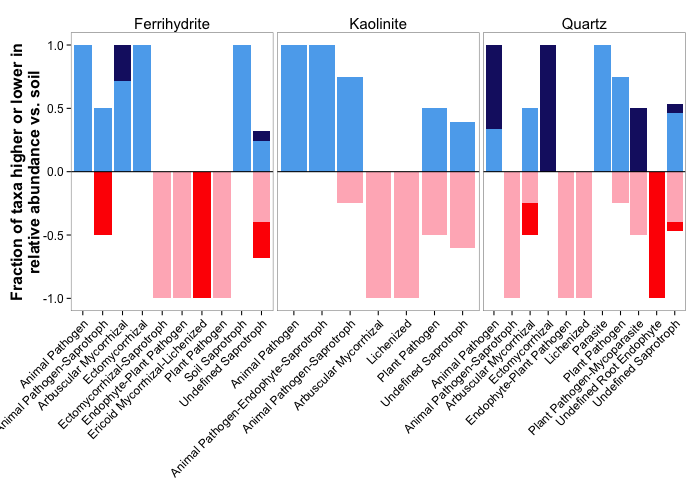

In [147]:
%%R -h 500 -w 700

FDR = 0.1

d = l2fc

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))

d = l2fc %>%
    filter(confidence==c("Highly Probable","Probable","Possible"))%>%
    group_by(guild,Trtmt)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,ifelse((padj >= FDR),0,1)))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(guild,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(guild,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(guild,Trtmt)%>%
    mutate(Sum = sum(n))%>%
    mutate(Shade = log(Sum))%>%
    arrange(guild)

d.pos = subset(d,Resp>0)
d.neg = subset(d,Resp<0)
d.pos$guild <- factor(d.pos$guild)
d.neg$guild <- factor(d.neg$guild)

p = ggplot()
#p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack") 
#p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack")
p = p + geom_bar(data=d.pos, aes(x=guild,y=Fract,fill=RespSignif),stat="identity", position="stack") 
p = p + geom_bar(data=d.neg, aes(x=guild,y=Fract,fill=RespSignif),stat="identity", position="stack")
#p = p + scale_x_discrete(limits=PhylumOrder)
p = p + facet_grid(~Trtmt,scales="free_x")
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(size = 12, angle=45, hjust=1))
p = p + theme(axis.text.y = element_text(size = 12))
p = p + scale_fill_manual(values=c("lightpink","red","steelblue2","midnightblue"))
#p = p + scale_alpha_continuous(range=c(0.3, 1),guide=F)
p = p + ylab("Fraction of taxa higher or lower in\nrelative abundance vs. soil") + xlab("")
p = p + ylim(c(-1,1))
p = p + theme(strip.text = element_text(size = 15),
              axis.title.y = element_text(size = 16, face = "bold"),
              legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
p = p + geom_hline(y = 0.0, linetype=1)

p